# Lab 3
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/syrkis/dlgs/blob/master/labs/lab3.ipynb)

# Contents and why we need this lab

This lab is about implementing neural networks yourself from scratch. 

All the modern frameworks for deep learning use automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation, and use this to build a simple neural network. Once you've done this lab you should have a very good understanding of what goes on below the hood in the modern framework such as [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/) or [JAX](https://github.com/google/jax). In particular the code we'll develop will look quite similar to the pytorch API.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. You can also use [colab](colab.to), which is a free online jupyter notebook.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [55]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from typing import Union
from math import tanh


class Var:
    """
    A variable which holds a number and enables gradient computations.
    """

    def __init__(self, val: Union[float, int], parents=None):
        assert type(val) in {float, int}
        if parents is None:
            parents = []
        self.v = val
        self.parents = parents
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for parent, grad in self.parents:
            parent.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, [(self, other.v), (other, self.v)])

    def __pow__(self, power: Union[float, int]) -> 'Var':
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def tanh(self) -> 'Var':
        return Var(tanh(self.v), [(self, 1 - tanh(self.v) ** 2)])

    def relu(self) -> 'Var':
        return Var(self.v if self.v > 0.0 else 0.0, [(self, 1.0 if self.v > 0.0 else 0.0)])

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

A few examples illustrate how we can use this:

In [56]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [57]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

It returns the dirivitive of f with respect to all of the variables with the gradiants since backwards is being called.

## Exercise b) How does the backward function work?

For the first example above, execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. Write down the sequence of calls to backprop for the first example above. 

It has redefined the operations of the integers, so when we recursively call the backward it will use these methods to return the dririvitive. It returns the gradiant. 

backprop(1.0)
    backprop(15.0)
        backprop(5.0)
        backprop(3.0)
    backprop(9.0)
        backprop(27.0)
    backprop(42.0)
    

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

it diffreantiates it again, and since we have not cleaned the dirivitieve. 

In [58]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


## Exercise d) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically compute the gradient:
$$
\frac{\partial f(x)}{\partial x} \approx \frac{f(x+dx)-f(x)}{dx}
$$
for a very small $dx$.

In [59]:
def finite_difference(fn, x, dx=1e-10):
    return (fn(x + dx) - fn(x))/dx

Use your finite difference function to compute the gradient of $f$ with respect to $a$ and $b$ in the following function: $f(x) = a \cdot b + b$, at a=3 and b=5.

In [60]:
# test function - try to change into other functions as well
def fa(x):
    return x * 5 + 5

def fb(x):
    return 3 * x + x

print(finite_difference(fa, 3))
print (finite_difference(fb, 5))

5.000018177270249
4.000000330961484


Write the same function using Nanograd `Var`s and verify that Nanograd computes the same gradients

In [61]:
x = Var(3.0)
y = Var(5.0)
h = x*y+y
h.backward()

for v in [x, y]:
    print(v)


Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=4.0000)


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels. You can modify it yourself if you want more or less challenging tasks.

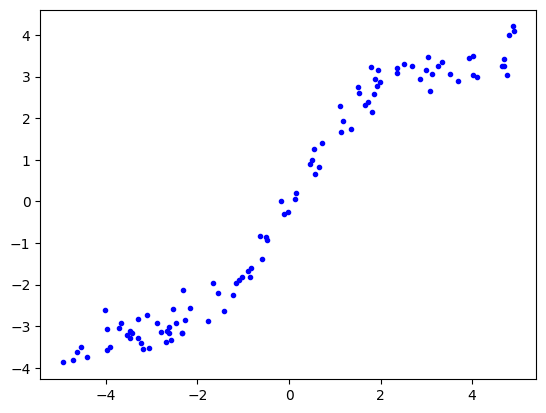

In [62]:
from math import sin
import random
import tqdm as tqdm
import matplotlib.pyplot as plt

def sample_data(noise=0.3):
    x = (random.random() - 0.5) * 10
    return x, sin(x) + x + random.gauss(0, noise)

train_data = [sample_data() for _ in range(100)]
val_data = [sample_data() for _ in range(100)]

for x, y in train_data:  
     plt.plot(x, y, 'b.')

plt.show()

# Building the neural network.

We'll create a feedforward neural network consisting of a series of dense layers. See the image below. Each dense layer is just a number of artificial neurons. In the image below each column of circles (neurons) is a dense layer. It's dense because the weight matrix is dense; there's a connection between every input and every output neuron in the layer.

The inputs to create a dense layer is following:

1. **The input size and output size**. We have to define the number of inputs and outputs. The inputs are the number of inputs to the layer, and the output size is the number of artificial neurons the layer has.
2. **Activation functions**. Each dense layer must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions.
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of a later exercice. For now we will just use simple Gaussians. See the `Initializer` class below.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

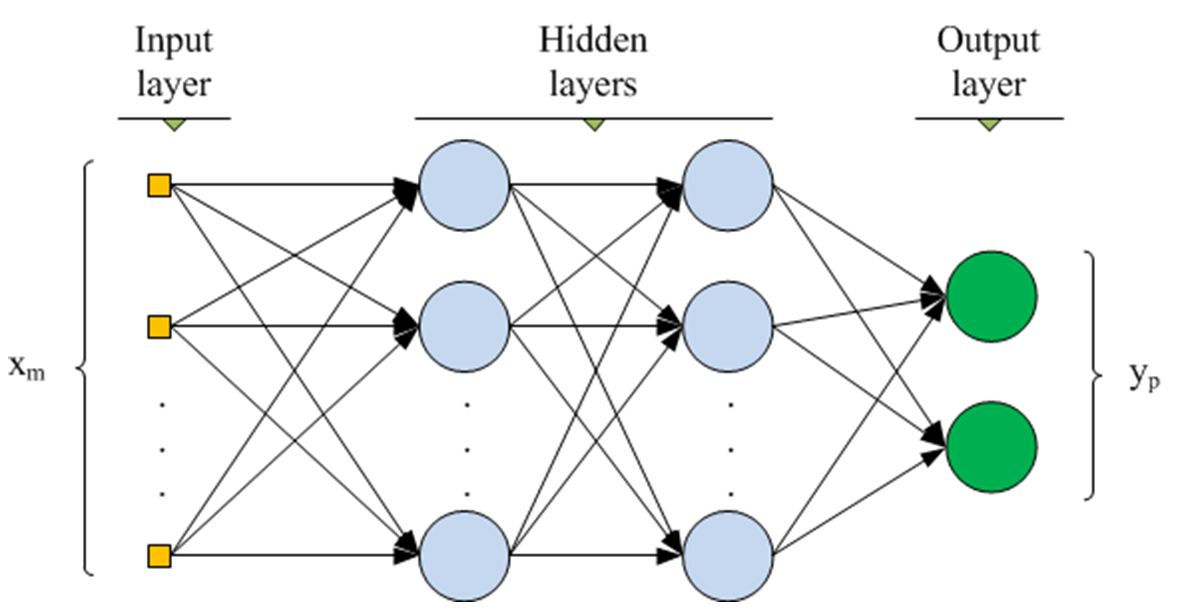

In [63]:
from typing import Sequence

class Initializer:

    def init_weights(self, n_in, n_out) -> Sequence[Sequence[Var]]:    
        raise NotImplementedError

    def init_bias(self, n_out) -> Sequence[Var]:
        raise NotImplementedError


class NormalInitializer(Initializer):

    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def init_weights(self, n_in, n_out):
        return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(0.0) for _ in range(n_out)]

### Exercise e) Dense layer

Complete the DenseLayer class below. The dense layer takes an input vector and computes an output vector corresponding to the value of each artificial neuron in the dense layer.

In [64]:

import math
class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer: Initializer = NormalInitializer()):
        """
          n_in: the number of inputs to the layer
          n_out: the number of output neurons in the layer
          act_fn: the non-linear activation function for each neuron
          initializer: The initializer to use to initialize the weights and biases
        """
        self.n_in = n_in
        self.n_out = n_out
        self.act_fn = act_fn
        self.initializer = initializer

        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
        """Returns all the vars of the layer (weights + biases) as a single flat list"""

        lst: Sequence[Var] = []
        
        for w in self.weights:
            for p in w:
                lst.append(p)
        for b in self.bias:
            lst.append(b)
        return lst
      
      
    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        """ 
        inputs: A n_in length vector of Var's corresponding to the previous layer outputs or the data if it's the first layer.

        Computes the forward pass of the dense layer: For each output neuron, j, it computes: act_fn(weights[i][j]*inputs[i] + bias[j])
        Returns a vector of Vars that is n_out long.
        """

        assert len(self.weights) == len(inputs), "weights and inputs must match in first dimension"

        out = [Var(0) for _ in range(len(self.bias))]
        for j in range(len(self.bias)):
            for i in range(len(self.weights)):
                out[j] += self.weights[i][j]*inputs[i]

        for x in range(len(out)):
            out[x] = self.act_fn(out[x] + self.bias[x])
        
        return out


Verify that your class is correct by running the code below, and verifying that `actual` is the same as `expected`. Here we define a small 3x2 dense layer with some fixed parameters and use numpy to compute the expected values.

In [65]:
import numpy as np
np.random.seed(0)

w = np.random.randn(3, 2)
b = np.random.randn(2)
x = np.random.randn(3)

expected = np.tanh(x@w+b)

class FixedInit(Initializer):
    """
    An initializer used for debugging that will return the w and b variables defined above regardless of the input and output size.
    """
    def init_weights(self, n_in, n_out):
        return [list(map(Var, r.tolist())) for r in w]
    def init_bias(self, n_out):
        return list(map(Var, b.tolist()))

layer = DenseLayer(3, 2, lambda x: x.tanh(), FixedInit())

var_x = list(map(Var, x.tolist()))
actual = layer.forward(var_x)
print("actual",actual)
print("expected",expected)

actual [Var(v=0.8935, grad=0.0000), Var(v=0.5275, grad=0.0000)]
expected [0.89347265 0.52750061]


## Exercise f) MLP

We'll now combine multiple DenseLayers into a neural network. We'll define a class to help us with this. We name it Multi-Layer Perceptron (MLP), since in the "old days", a single dense layer neural network was called a perceptron. It takes a list of DenseLayer as input and defines a forward function. The forward function takes a vector of inputs, the data inputs, and return a vector of outputs, the output of the neural network, after being passed through each layer of the network. It also has a parameters function which just returns all the parameters of the layers as a single flat list.

Complete the MLP class below.

In [66]:
class MLP:
    def __init__(self, layers: Sequence[DenseLayer]):
        self.layers = layers

    def parameters(self) -> Sequence[Var]:
        """ Returns all the parameters of the layers as a flat list"""
        
        lst: Sequence[Var] = []
        for layer in self.layers:
          for p in layer.parameters():
            lst.append(p)
        return lst
        
    def forward(self, x: Sequence[Var]) -> Sequence[Var]:
        """
        Computes the forward pass of the MLP: x = layer(x) for each layer in layers
        """
        for layer in self.layers:
          x = layer.forward(x)
        return x



## Exercise g) SGD

Now we need code that will perform the stochastic gradient descent. Complete the class below

In [67]:
class SGD:
    def __init__(self, parameters: Sequence[Var], learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def zero_grad(self):
        """ Set the gradient to zero for all parameters """
        for p in self.parameters:
            p.grad = 0

    def step(self):
        """Performs a single step of SGD for each parameter: p = p - learning_rate * grad_p """
        
        for p in self.parameters:
            p.v = p.v - self.learning_rate * p.grad
            


# Loss functions

We are only missing a loss function now. We're doing regression so we'll use the L2 loss function $L2(t, y) = (t-y)^2$, where $t$ is the expected output (the target) and $y$ is the output of the neural network.

In [68]:
def squared_loss(t: Var, y: Var) -> Var:  
    return (t-y)**2

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Let's see how it works.

In [69]:
mlp = MLP([
    DenseLayer(1, 5, lambda x: x.tanh()),
    DenseLayer(5, 1, lambda x: x)
])

x, t = sample_data()
x = Var(x)
t = Var(t)
y = mlp.forward([x])

print("y" ,y[0])

loss = squared_loss(t, y[0])
loss.backward()

y Var(v=-0.0550, grad=0.0000)


and the gradients will be calculated:

In [70]:
for i,layer in enumerate(mlp.layers):
    print("layer", i, layer)

layer 0 Weights: [[Var(v=-0.0753, grad=-3.3993), Var(v=-0.1579, grad=0.4559), Var(v=-0.1183, grad=-0.2030), Var(v=-0.1578, grad=-1.1760), Var(v=-0.0987, grad=0.6044)]] Biases: [Var(v=0.0000, grad=-1.4383), Var(v=0.0000, grad=0.1929), Var(v=0.0000, grad=-0.0859), Var(v=0.0000, grad=-0.4976), Var(v=0.0000, grad=0.2557)]
layer 1 Weights: [[Var(v=0.2335, grad=1.1198)], [Var(v=-0.0348, grad=2.2682)], [Var(v=0.0146, grad=1.7332)], [Var(v=0.0897, grad=2.2672)], [Var(v=-0.0425, grad=1.4564)]] Biases: [Var(v=0.0000, grad=-6.3573)]


## Exercise h) Putting it all together

We are ready to train some neural networks!

We'll train the neural network for 100 gradient updates. Each gradient will be calculated on the average loss over a minibatch of samples. Read and understand the code below. 
Answer the inline comment questions. 
We'll plot the loss for each batch, which should decrease steadily.

100%|██████████| 100/100 [00:02<00:00, 37.58it/s]


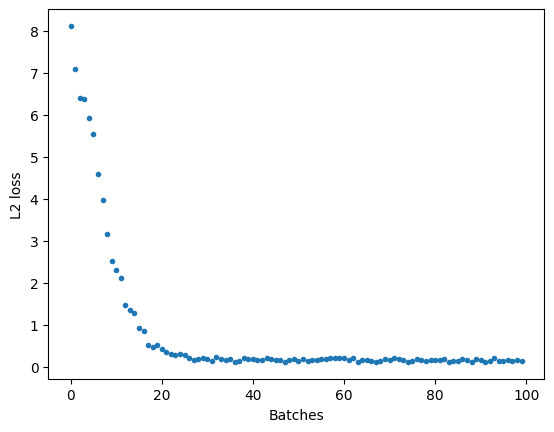

In [71]:
mlp = MLP([
    DenseLayer(1, 16, lambda x: x.tanh()),
    DenseLayer(16, 1, lambda x: x)
]) # What does this line do? - Make the dense layers

"""
Initilizes the Multi-Layer Perceptron over 2 dense layers. Layer one takes in a signle neuron and 
outputs 16 neurons and then the other layer that takes in 16 neurons and outputs 1 neuron. The first
layer applies the fuction tan().
"""

learning_rate = 0.01 # Try different learning rates
optim = SGD(mlp.parameters(), learning_rate) # What does this line do? - Inilitilizes the gradient descent with the parameters and learning rate


batch_size = 64
losses = []
for i in tqdm.tqdm(range(100)):
    loss = Var(0.0)
    for _ in range(batch_size): # What does this loop do? - We run 64 times over 100 test data
        
        x, y_target = random.choice(train_data) # What does this line do? - We take a random choice from testing data
        x = Var(x)
        y_target = Var(y_target)
        y = mlp.forward([x])
        loss += squared_loss(y_target, y[0])

    loss = loss / Var(batch_size) # What does this line do? - Computes the loss per batch size
    losses.append(loss.v)
    optim.zero_grad() # Why do we need to call zero_grad here? - Clean the gradiants in order not to have old data there
    loss.backward() # What does this line do? - Computes the gradiant. To find of the gradiant of the graph is making an improvement
    optim.step()  # What does this line do? - Finds the stochastic gradient descent of all the parameters

plt.plot(losses, '.')
plt.ylabel('L2 loss')
plt.xlabel('Batches')
plt.show()

The plot should look similar to: 

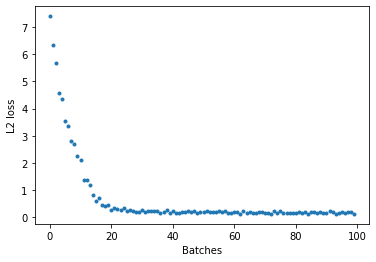

Let's also plot the data and what the Neural Network has learned.

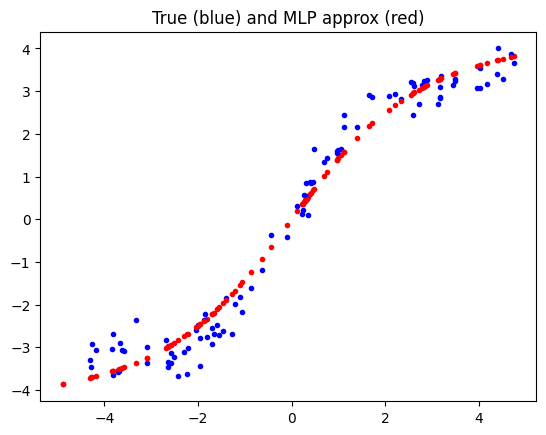

In [72]:
for _ in range(100):
    x, y_target = sample_data()
    y = mlp.forward([Var(x)])
    plt.plot(x, y_target, 'b.')
    plt.plot(x, y[0].v, 'r.')

plt.title('True (blue) and MLP approx (red)')
plt.show()

The plot should look similar to this: 

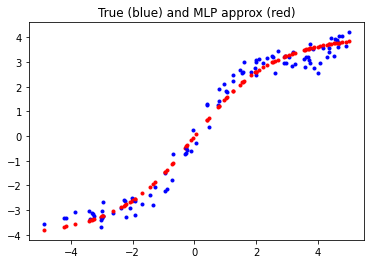